In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import sys
sys.path.append('../')
import os
from utils import prepare_data_single_fidelity

# Parameters
n_splits = 4
n_samples = [1000, 2000, 4000, 8000, 16000, 32000, 64000]
discretizations = ['h1', 'h2', 'h3']
resolutions = [50, 25, 10]
colors = {'h1': 'blue', 'h2': 'green', 'h3': 'red'}
markers = {'h1': 'o', 'h2': 's', 'h3': 'D'}
linestyles = {'h1': '-', 'h2': '--', 'h3': ':'}

# Prepare dictionary for RMSE results
rmse_test_all = {disc: [] for disc in discretizations}

# Iterate over discretizations
for discretization in discretizations:
    print(f"Processing discretization level: {discretization}")

    # Load training and test data for each discretization
    X_train, y_train, X_test, y_test = prepare_data_single_fidelity(
        115200,
        f"../data/X_train_{discretization}.csv",
        f"../data/y_train_{discretization}.csv",
        f"../data/X_test_{discretization}.csv",
        f"../data/y_test_{discretization}.csv"
    )

    for n_sample in n_samples:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        X, y = X_train[:n_sample, :], y_train[:n_sample, :]
        rmse_test = []
        predictions_train = []
        predictions_test = []

        
        for fold_var, (train_index, val_index) in enumerate(kf.split(y), start=1):
            X_val_k = X[val_index,:]
            y_val_k = y[val_index]

            # Load model and evaluate RMSE
            model_path = f'../models/single_fidelity/resolution_{discretization}/samples_{n_sample}/model_fold_{fold_var}.keras'
            model = load_model(model_path)
            rmse_test.append(np.sqrt(np.mean((model(X_val_k).numpy() - y_val_k) ** 2)))
            predictions_train.append(model(X_train).numpy())
            predictions_test.append(model(X_test).numpy())
        
        predictions_train = np.mean(predictions_train, axis=0)
        predictions_test = np.mean(predictions_test, axis=0)

        # Define the directory path
        output_dir = f'../data/predictions_single_fidelity/resolution_{discretization}/samples_{n_sample}/'

        # Create the directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        # Save the files
        np.savetxt(os.path.join(output_dir, 'predictions_train.csv'), predictions_train, delimiter=",")
        np.savetxt(os.path.join(output_dir, 'predictions_test.csv'), predictions_test, delimiter=",")

        # Append RMSE results for current sample size and discretization
        rmse_test_all[discretization].append(rmse_test)


Processing discretization level: h1
Processing discretization level: h2
Processing discretization level: h3


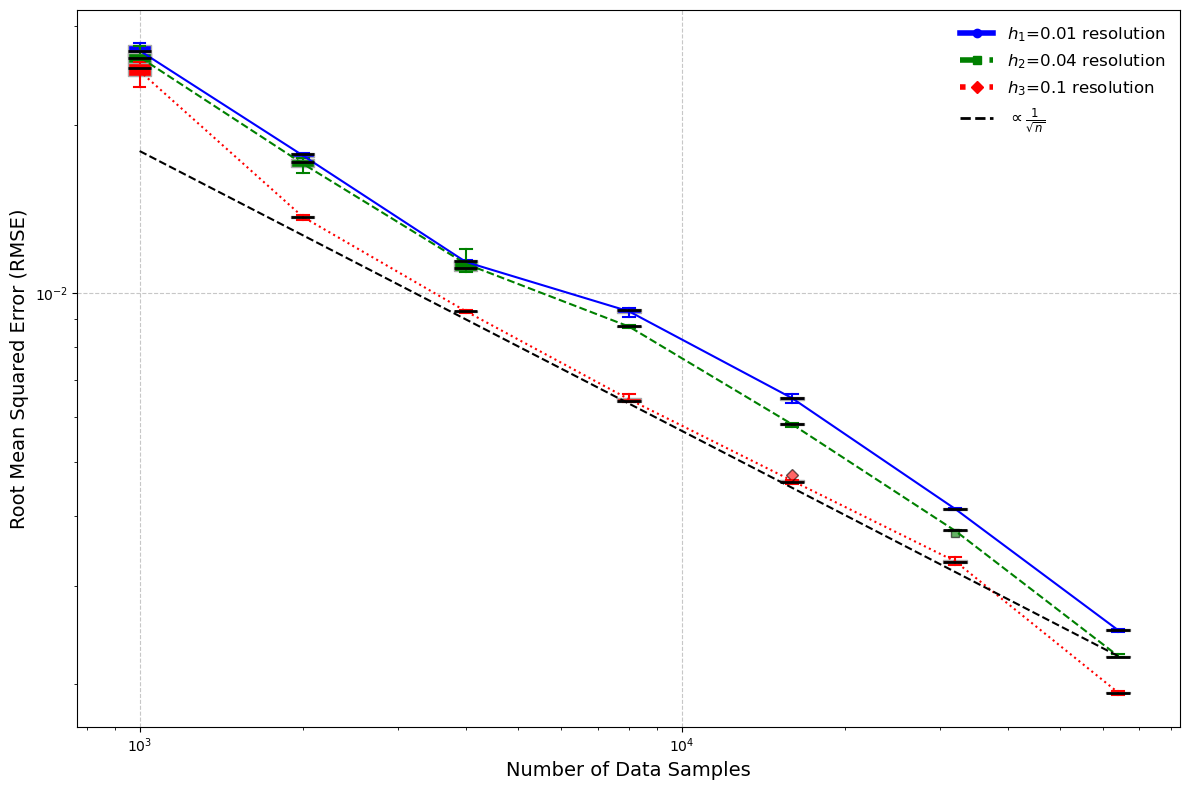

In [35]:
plt.figure(figsize=(12, 8))
custom_lines = [plt.Line2D([0], [0], color=colors[d], lw=4, linestyle=linestyles[d], marker=markers[d]) for d in discretizations]

# Iterate over each discretization and create boxplots for each sample size
for i, discretization in enumerate(discretizations):
    positions = n_samples  # Ensure the positions correspond to sample sizes
    
    # Create boxplots with a fixed, increased width and enhanced visual properties
    plt.boxplot(
        rmse_test_all[discretization],
        positions=positions,
        widths=np.array(n_samples)*0.1,  # Increased fixed width for better visibility
        patch_artist=True,
        boxprops=dict(facecolor=colors[discretization], edgecolor='darkgray', linewidth=1),
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color=colors[discretization], linewidth=1.5, linestyle='-'),
        capprops=dict(color=colors[discretization], linewidth=1.5),
        flierprops=dict(
            marker=markers[discretization],
            color=colors[discretization],
            markerfacecolor=colors[discretization],
            alpha=0.6,
            markersize=6,
            linestyle='none'
        ),
        showfliers=True
    )

# Plot convergence lines for each discretization level
for i, d in enumerate(discretizations):
    pos = n_samples
    plt.plot(pos, np.mean(rmse_test_all[d], axis=1), color=colors[d], linestyle=linestyles[d])

# Plot theoretical convergence line
sample_positions = n_samples
convergence_line = 1 * np.sqrt(64000) / np.sqrt(n_samples) * np.mean(rmse_test_all['h2'][-1])
plt.plot(sample_positions, convergence_line, 'k--')

# Final adjustments to plot
plt.xlabel('Number of Data Samples', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=14)

resolutions = ['$h_1$=0.01','$h_2$=0.04','$h_3$=0.1']

plt.legend(custom_lines + [plt.Line2D([0], [0], color='black', linestyle='--', lw=2)],
           [f'{r} resolution' for r in resolutions] + [r'$\propto \frac{1}{\sqrt{n}}$'], 
           loc='upper right', fontsize=12, frameon=False)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig("../images/convergence_error_single_fidelity.png", dpi=300, bbox_inches='tight')